In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


# Assignment: Linear and logistic regression
The assignment consists of constructing two separate models for predicting the real estate prices in the dataset: one with linear and one with logistic regression.

1. Linear regression model: construct a linear regression model for predicting the continuous target variable "Y house price of unit area" in the dataset.

2. Logistic regression model: convert the target variable into a binary-valued one according to whether the original target value is above or below the average house price of unit area (within the training set samples), and construct a binary classifier for predicting its value with logistic regression.

Both models should be validated, with appropriate metrics presented and discussed.

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

# data (as pandas dataframes)
X = real_estate_valuation.data.features
y = real_estate_valuation.data.targets

# variable information
print (real_estate_valuation.data)

{'ids':       No
0      1
1      2
2      3
3      4
4      5
..   ...
409  410
410  411
411  412
412  413
413  414

[414 rows x 1 columns], 'features':      X1 transaction date  X2 house age  \
0               2012.917          32.0   
1               2012.917          19.5   
2               2013.583          13.3   
3               2013.500          13.3   
4               2012.833           5.0   
..                   ...           ...   
409             2013.000          13.7   
410             2012.667           5.6   
411             2013.250          18.8   
412             2013.000           8.1   
413             2013.500           6.5   

     X3 distance to the nearest MRT station  X4 number of convenience stores  \
0                                  84.87882                               10   
1                                 306.59470                                9   
2                                 561.98450                                5   
3                     

## Business Understanding

###### The goal:
- The goal of this analysis is to create models that can predict house prices per unit area using different property features, such as:

    - House age  
    - Distance to the nearest MRT station  
    - Number of convenience stores nearby  
    - Latitude and longitude of the property  
    - Transaction date 

###### Requirements & Limits:

- Data: The dataset has 414 records with important details about house prices.
    Feature Processing: Some changes might be needed, like adjusting values, handling unusual data, or changing variables.
    Model Choice: Linear regression will be used to predict prices, and logistic regression will be used if classification is needed.

###### Expected Results:

- A model that can predict house prices based on property details.
    Insights into which factors impact house prices the most.
  

## Data Understanding
 
- We use the market historical data set of real estate valuation are collected from Sindian Dist., New Taipei City, Taiwan. 
- The dataset consists of 414 rows and 8 columns to real estate transactions.
- Availible data:
    - Transaction date
    - house age
    - distance ti the nearest MRT station
    - number of convenience stores
    - latitude
    - longitude
    - house price of unit area

- Data type: float64(5), int64(1)
- value distributions:
   use .describe() to show the value distributions, 
   - for example, house age:
      - Range: 0 to 43.8 years
      - mean: 17.71 years
      - std Dev: 11.39
      - Interpretation: Houses vary widely in age, with a good number of newer houses (0 years).
- No missing values
- Latitude & Longitude: The range seems reasonable, but mapping the coordinates could reveal inconsistencies.


In [4]:
# Get descriptive statistics
describe_x = X.describe()
describe_y = y.describe()

# Join both summaries
summary = describe_x.join(describe_y)

# Display result
print(summary)


       X1 transaction date  X2 house age  \
count           414.000000    414.000000   
mean           2013.148971     17.712560   
std               0.281967     11.392485   
min            2012.667000      0.000000   
25%            2012.917000      9.025000   
50%            2013.167000     16.100000   
75%            2013.417000     28.150000   
max            2013.583000     43.800000   

       X3 distance to the nearest MRT station  \
count                              414.000000   
mean                              1083.885689   
std                               1262.109595   
min                                 23.382840   
25%                                289.324800   
50%                                492.231300   
75%                               1454.279000   
max                               6488.021000   

       X4 number of convenience stores  X5 latitude  X6 longitude  \
count                       414.000000   414.000000    414.000000   
mean                   

In [5]:
print(X.dtypes)
print(y.dtypes)

X1 transaction date                       float64
X2 house age                              float64
X3 distance to the nearest MRT station    float64
X4 number of convenience stores             int64
X5 latitude                               float64
X6 longitude                              float64
dtype: object
Y house price of unit area    float64
dtype: object


## Data Preparation
#### Cleaning the data:
   - There are no missing values, outliers, or nonsensical values. Therefore, we haven't done anything.
      
#### Feature Selection:
   - We use all feature.
   
#### Plitting the Data:

 To evaluate the model's performance on unseen data, we split the data into two subsets: 
    - Training data (80%) for training the model.
    - Test data (20%) for evaluating how well the model generalizes to new data.
    
  We use `train_test_split()` from scikit-learn to divide the data into training and test sets. 


In [6]:
#Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
print(X_train.shape, X_test.shape, y_train.shape)

(331, 6) (83, 6) (331, 1)


We use `head()` to print the first few rows of the features dataset. Make sure everything looks correct before moving on to training.

In [7]:
print(X.head()) 
feature_names = X.columns.tolist()

   X1 transaction date  X2 house age  X3 distance to the nearest MRT station  \
0             2012.917          32.0                                84.87882   
1             2012.917          19.5                               306.59470   
2             2013.583          13.3                               561.98450   
3             2013.500          13.3                               561.98450   
4             2012.833           5.0                               390.56840   

   X4 number of convenience stores  X5 latitude  X6 longitude  
0                               10     24.98298     121.54024  
1                                9     24.98034     121.53951  
2                                5     24.98746     121.54391  
3                                5     24.98746     121.54391  
4                                5     24.97937     121.54245  


## Creating the Binary Target:
Compute the average house price per unit area from the training set and convert the target to binary (1 if above average, 0 if below average).

In [8]:
# Calculate the threshold from training targets
threshold = y_train.mean()

# Convert continuous target to binary: 1 if above threshold, 0 otherwise
y_train_binary = (y_train > threshold).astype(int)
y_test_binary  = (y_test > threshold).astype(int)

print("Threshold:", threshold)
print("Binary distribution in training set:")
print(y_train_binary.value_counts())


Threshold: Y house price of unit area    38.391541
dtype: float64
Binary distribution in training set:
Y house price of unit area
1                             174
0                             157
Name: count, dtype: int64


## Data standardization

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
print(X_train_scaled_df.head())

   X1 transaction date  X2 house age  X3 distance to the nearest MRT station  \
0             0.001128      2.344015                               -0.823965   
1             0.296351     -0.821281                                0.951418   
2            -1.777321     -0.900856                                0.917224   
3            -0.297651      1.707419                               -0.469361   
4             0.890353     -0.865489                               -0.345357   

   X4 number of convenience stores  X5 latitude  X6 longitude  
0                         0.968042    -0.147066      0.455057  
1                        -0.049170    -0.743117     -1.355926  
2                        -0.388241    -0.504055     -1.427483  
3                         1.307112     0.065523      0.739277  
4                         0.289900     0.260463      0.953278  


## Modeling

### Linear regression model

model = LinearRegression()
Linear Regresion model is used to predict the numerical values of the housing prices.

model.fit(X_train, y_train)
The model is trained with the predetermined training data.

y_pred = model.predict(X_test)
The test data is then fed to the model to predict the numerical values prices of the houses.

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
Root Mean Squared Error (RMSE) is a common metric that evaluates the performance of the linear regression model.

r2 = r2_score(y_test, y_pred)
R² score is another common metric that evaluates performance of linear regression model.

plt.scatter(y_test, y_pred, alpha=0.5, color='cyan')
plt.xlabel("Actual House Price per Unit Area")
plt.ylabel("Predicted House Price per Unit Area")
plt.title("Actual vs Predicted House Prices")
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='red', linestyle='dashed')  # Reference Line
plt.show()

This creates the diagram to easily view the model's performance.

Root Mean Squared Error (RMSE): 7.31
R² Score: 0.6811


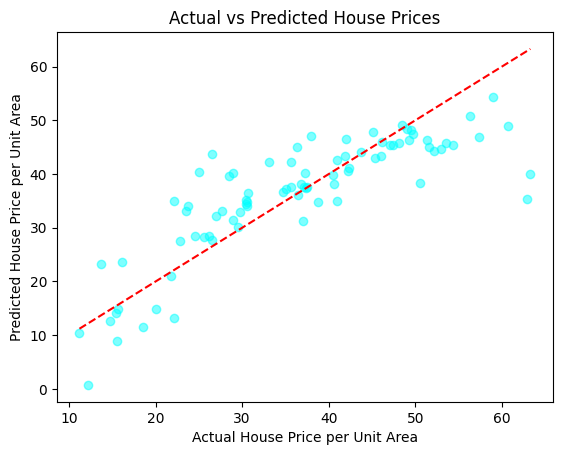

In [10]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

plt.scatter(y_test, y_pred, alpha=0.5, color='cyan')
plt.xlabel("Actual House Price per Unit Area")
plt.ylabel("Predicted House Price per Unit Area")
plt.title("Actual vs Predicted House Prices")
plt.plot([min(y_test.values), max(y_test.values)], [min(y_test.values), max(y_test.values)], color='red', linestyle='dashed')  # Reference Line
plt.show()

### Logistic regression model
- **random_state=42**: Ensures reproducibility of the results.
- An instance of LogisticRegression is created with a specified random state for reproducibility.
- The model is trained using the scaled training data **X_train_scaled** and the binary target variable **y_train_binary**.
- The coefficients of the trained model are retrieved, representing the importance of each feature.
- A DataFrame is created to pair each feature name with its coefficient and is sorted in descending order based on the coefficient values.


In [13]:
from sklearn.linear_model import LogisticRegression

# Build the logistic regression model
reg = LogisticRegression(solver='lbfgs', random_state=42)
reg.fit(X_train_scaled, y_train_binary.values.ravel())


# Retrieve coefficients (and intercept)
print("Coefficients: ", reg.coef_)
print("Intercept: ", reg.intercept_)

Coefficients:  [[ 0.23384218 -0.60812729 -2.33203175  0.55145938  0.94555496 -0.14130285]]
Intercept:  [-0.52367405]


**Coefficients**: The coefficients represent the relationship between each feature and the target variable.
- **Positive Coefficients**: Features with positive coefficients indicate that as the value of these features increases, the likelihood of the house price being above the average (threshold) also increases. In other words, these features contribute to higher house prices.
- **Negative Coefficients**: Features with negative coefficients indicate that as the value of these features increases, the likelihood of the house price being above the average (threshold) decreases. In other words, these features contribute to lower house prices.

**Intercept**: The intercept is the value of the target variable when all feature values are zero. It represents the baseline level of the target variable in the absence of any feature influence.

## Evaluation
- The fifth phase is to evaluate the model.
- How well does the model perform?
- Does it meet the business requirements?
- Logistic regression:
    -- Predict test data
    -- calculate evaluation metrics
    -- confusion matrix
    -- permutation importance


## Deployment
- The final phase is to deploy the model.
- How will the model be used in practice?
- How will the results be communicated?
- This phase may involve creating a recommendation of how to use the model in practice, or what to do next.